# Missing data handling strategies

| % Missing | Recommended Strategy                       | Notes / Details |
|----------:|--------------------------------------------|-----------------|
| **0–5%**  | Simple imputation                          | • Impact is minimal<br>• Mean/median/mode (numeric)<br>• Most frequent (categorical) |
| **5–20%** | Targeted imputation                        | • Investigate mechanism (MCAR/MAR/MNAR)<br>• Mean/median (numeric)<br>• Mode or category-specific (categorical)<br>• Predictive models (regression, kNN, MICE) if correlated |
| **20–40%**| Advanced imputation                        | • Multivariate imputation (MICE, kNN) 
| **40–60%**| Domain-specific imputation **or** consider dropping | • Model- or domain-based (e.g., regression, time-series inference)<br>• Remain ulfilled if imputation is not feasible |
| **>60%**  | Remain ulfilled the variable                          | • Unless strong domain rules allow reliable imputation |


In [364]:
# Imports and read data

# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy import stats
from scipy.stats import ks_2samp, skew

# Define Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model tried
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Model evaluation
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# Custom function
from random_test import assess_randomness


data = pd.read_csv('Project_csv/data.csv')
data = data.drop(columns = {"Unnamed: 0", "Unnamed: 0.1"}, axis =1)
data.head(1)


,equality_female_graduates (%),equality_female_management (%),equality_female_employees (%),equality_leave_primary (W),equality_leave_secondary (W),equality_gender_pay (%),equality_gender_pay_improvement (%),equality_gender_bonus (%),equality_gender_directors (%),equality_gender_appointments (%),...,equality_lgbt_pay (%),equality_lgbt_management (%),equality_disability_employees (%),equality_disability_pay (%),equality_disability_management (%),equality_gender_pay_previous (%),equality_parker (Y/N),equality_bame_reporting (Y/N),equality_lgbt_reporting (Y/N),equality_disability_reporting (Y/N)
0,NaN,24.0,21.0,NaN,NaN,41.0,8.0,78.0,0.273,0.2,...,NaN,NaN,NaN,NaN,NaN,49.0,1.0,0.0,0.0,0.0


In [229]:
# Drop all invalid data

# 1. Drop all values outside of 0-100% for numeric columns
pct_columns = [col for col in data.columns if '(%)' in col]
for col in pct_columns:
    data[col] = data[col].where((data[col] >= 0) & (data[col] <= 100))
    
# 2. Drop all values outside of week range <52
w_columns = [col for col in data.columns if '(W)' in col]
for col in w_columns:
    data[col] = data[col].where((data[col] >= 0) & (data[col] <= 53))
    
# 3. Drop all values that is not 0,1,2,3,4
level_columns = [col for col in data.columns if 'Level(4-0)' in col]
for col in level_columns:
    data[col] = data[col].where(data[col].isin([0, 1, 2, 3, 4]))
    

In [358]:
# Overview how much missing

missing_percent = data.isna().mean() * 100
missing_percent = missing_percent.sort_values(ascending=False)
missing_percent


equality_disability_management (%)     100.000000
equality_disability_pay (%)            100.000000
equality_lgbt_management (%)           100.000000
equality_lgbt_pay (%)                  100.000000
equality_bame_pay (%)                   96.969697
equality_lgbt_employees (%)             92.929293
equality_bame_management (%)            89.898990
equality_disability_employees (%)       88.888889
equality_bame_employees (%)             79.797980
equality_female_graduates (%)           69.696970
equality_leave_secondary (W)            58.585859
equality_leave_primary (W)              49.494949
equality_gender_bonus (%)               14.141414
equality_gender_pay_previous (%)        14.141414
equality_gender_pay_improvement (%)     13.131313
equality_gender_pay (%)                 12.121212
equality_female_management (%)           8.080808
equality_wise_level ,Level(4-0)          3.030303
equality_parker (Y/N)                    3.030303
equality_bame_reporting (Y/N)            3.030303


In [230]:
# Binned all programs according to the % of missing data
# <5%, < 5–20%, 20–40%, 40–60%, >60%

# Define groups
gr_0 = missing_percent[missing_percent == 0].index.tolist()
gr_5 = missing_percent[(missing_percent > 0) & (missing_percent <= 5)].index.tolist()
gr_20 = missing_percent[(missing_percent > 5) & (missing_percent <= 20)].index.tolist()
gr_40 = missing_percent[(missing_percent > 20) & (missing_percent <= 40)].index.tolist()
gr_60 = missing_percent[(missing_percent > 40) & (missing_percent <= 60)].index.tolist()
gr_100 = missing_percent[missing_percent > 60].index.tolist()
                                              

### Group 1 — Missing Less Than 5% of Data

| Data Type | Recommended Action | Notes |
|------------|--------------------|-------|
| **Numeric** | Fill with **mean**, **median**, or **mode** | Minimal impact on analysis |
| **Categorical** | Fill with **most frequent** value | Maintains data consistency |

In [231]:
gr_5

['equality_wise_level ,Level(4-0)',
 'equality_parker (Y/N)',
 'equality_bame_reporting (Y/N)',
 'equality_lgbt_reporting (Y/N)',
 'equality_disability_reporting (Y/N)',
 'equality_female_employees (%)']

#### Numerical values

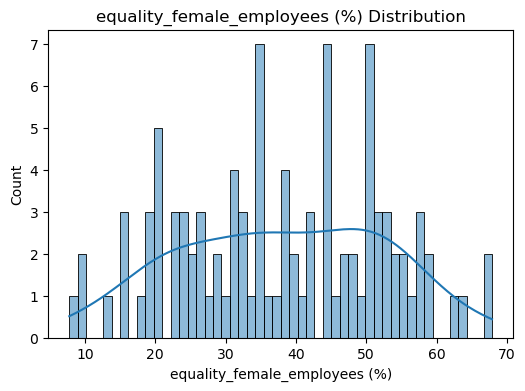

In [232]:
# Visualisation for numerica values

numeric_list = ['equality_female_employees (%)']

for col in numeric_list:  #  Used the loop to re-use the code later where the list can be longer
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], bins = 50, kde=True)
    plt.title(f"{col} Distribution")
    plt.show()

In [233]:
# Calculation Skewness and Kurtosis

skew_df = data[numeric_list].skew().reset_index()
skew_df.columns = ['Column', 'Skewness']


kurt_df = data[numeric_list].kurt().reset_index()
kurt_df.columns = ['Column', 'Kurtosis']

stats_df = pd.merge(skew_df, kurt_df, on='Column')

print(stats_df)

                          Column  Skewness  Kurtosis
0  equality_female_employees (%) -0.074973 -0.854854



| Variable | Distribution Shape | Skewness | Kurtosis | Description | Statistical Function |
|-----------|--------------------|-----------|-----------|--------------|----------------------|
| **equality_female_employees** | Fairly symmetric | -0.074973 | -0.854854 | The distribution looks balanced with no heavy skewness or extreme outliers. | Mean |




In [234]:
# Fill out missed values

data_5 = data.copy()

for col in numeric_list:
    skew_value = data_5[col].skew(skipna=True)
    if abs(skew_value) < 1:
        # assign back; do NOT use inplace=True on a slice
        data_5.loc[:, col] = data_5[col].fillna(data_5[col].mean())
    else:
        data_5.loc[:, col] = data_5[col].fillna(data_5[col].median())

#### Categorical values

In [235]:
# Fill out missed values with mode

cols_to_fill = [
    'equality_parker (Y/N)',
    'equality_bame_reporting (Y/N)',
    'equality_lgbt_reporting (Y/N)',
    'equality_disability_reporting (Y/N)',
    'equality_wise (Y/N)',
    'equality_wise_level ,Level(4-0)'
]

for col in cols_to_fill:
    mode_value = data_5[col].mode()[0]  # get the most frequent value
    data_5[col] = data_5[col].fillna(mode_value)

### Group 2 — Missing Between 5% and 20% of Data

- Investigate the cause of missingness — determine if it’s MCAR, MAR, or MNAR.

| Mechanism | Recommended Strategy |
|------------|----------------------|
| **MCAR** (Missing Completely at Random) | Safe to impute with mean/median for numeric variables and mode for categorical variables. |
| **MAR** (Missing at Random) | If correlated with other variables, recommended to use predictive models such as regression, kNN, or MICE. |
| **MNAR** (Missing Not at Random) | Consider dropping the variable unless strong domain rules allow safe imputation. |


In [237]:
gr_20

['equality_gender_pay (%)', 'equality_female_management (%)']

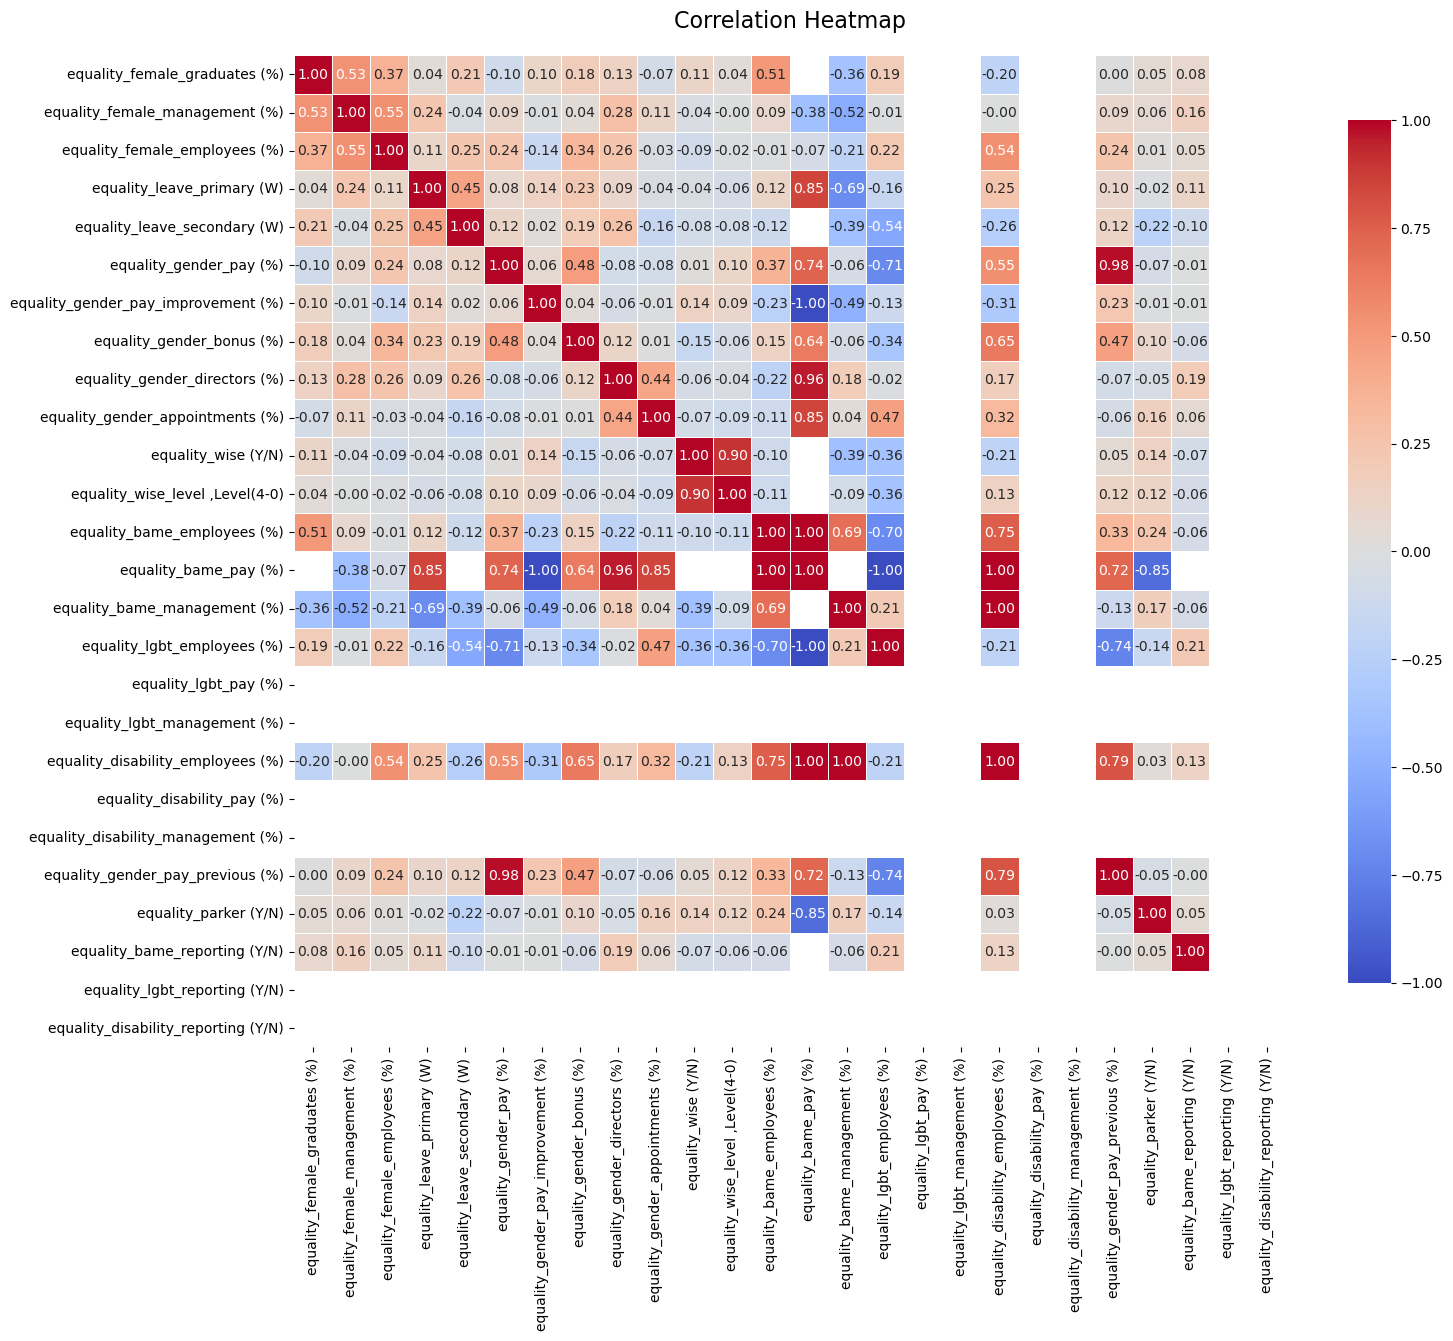

In [359]:
# Calculate correlation matrix 

correlation_matrix = data.corr()

# Create the heatmap
plt.figure(figsize=(16, 14))  
sns.heatmap(correlation_matrix, 
            annot=True,           
            fmt='.2f',            
            cmap='coolwarm',      
            center=0,            
            square=True,          
           linewidths=0.5,       
            cbar_kws={"shrink": 0.8})  

plt.title('Correlation Heatmap', fontsize=16, pad=20)
plt.show()

In [239]:
#  Randomness test

filtered_cols = missing_percent[missing_percent < 20].index

# Create a new DataFrame with only those columns
data_filtered = data_5[filtered_cols]

# Apply to filtered dataset

assessment = assess_randomness(data_filtered, gr_20, threshold=0.3)
print('Filtered')
for target, info in assessment.items():
    print(f"{target}:")
    print(f"  Result: {info['result']}")
    if info['correlated_columns']:
        print(f"  Correlated with:")
        for col, corr_val in info['correlated_columns']:
            print(f"    - {col}: {corr_val:.3f}")
    else:
        print(f"  Correlated with: []")
    print()
    

Filtered
equality_gender_pay (%):
  Result: Random (MCAR)
  Correlated with: []

equality_female_management (%):
  Result: Not Random (MAR/MNAR)
  Correlated with:
    - equality_female_employees (%): 0.545



| Variable | Relationship Type | Recommended Imputation Method |
|-----------|-------------------|-------------------------------|
| **equality_gender_pay** | MCAR | Fill with **mean**, **median**, or **mode** |
| **equality_female_management** | MAR Moderate relationship with a column with missing | MICE, Linear regression, Baysian |


#### 1. equality_female_management	

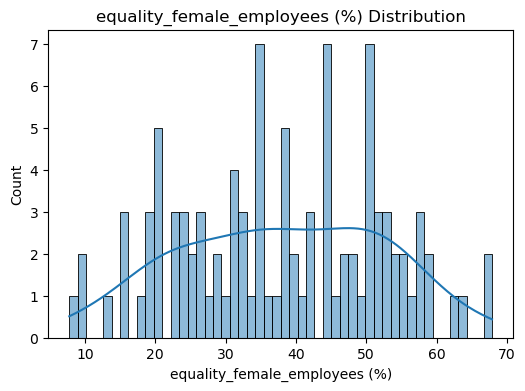

In [240]:
numeric_list = ['equality_female_employees (%)']

for col in numeric_list:  
    plt.figure(figsize=(6,4))
    sns.histplot(data_5[col], bins = 50, kde=True)
    plt.title(f"{col} Distribution")
    plt.show()

#### MICE

In [241]:
# Define the three datasets

columns_sets = [
    # Dataset 1: filled out columns + columns with correlation
    gr_0 + gr_5 + [
        "equality_female_employees (%)",
        "equality_gender_directors (%)",
        "equality_female_management (%)"
    ],
    # Dataset 2: a column with the correlation only
    [
        "equality_female_employees (%)",
        "equality_female_management (%)"
    ],
    # Dataset 3: columns with the highest importance
    [
        "equality_female_employees (%)",
        "equality_gender_directors (%)",
        "equality_female_management (%)"
    ]
]


In [242]:
# Define the mode

rf_est = RandomForestRegressor(
    n_estimators=200,      # a bit more trees for stability
    max_depth=6,          # limit depth to avoid overfitting
    min_samples_leaf=3,   # smoother predictions
    n_jobs=-1,            # use all cores
    random_state=42
)

mice_rf = IterativeImputer(
    estimator=rf_est,
    max_iter=40,           # default=10; more iterations → better convergence
    sample_posterior=True, # makes imputations stochastic (proper MI flavour)
    imputation_order="random",  # more stable when patterns of missingness differ
    skip_complete=False,
    random_state=42
)

In [244]:
#  run of MICE with multiple column sets
data_original = data_5.copy()

results = []

mice_rf = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    random_state=42
)

for i, mice_female_management in enumerate(columns_sets, 1):
    
    # Only work inside the loop (no overwriting global data)
    mice_work = data_5[mice_female_management].copy()
    
    # Track missing target
    target_missing_mask = mice_work['equality_female_management (%)'].isnull()
    
    # Impute
    fem_imputed = pd.DataFrame(
        mice_rf.fit_transform(mice_work),
        columns = mice_work.columns,
        index = mice_work.index
    )
    
    # Evaluate on known values
    known_mask = ~target_missing_mask
    X = mice_work.loc[known_mask].drop('equality_female_management (%)', axis=1)
    y = mice_work.loc[known_mask, 'equality_female_management (%)']
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    cv_mae = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error')
    cv_r2 = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
    
    mean_mae = -cv_mae.mean()
    mean_r2 = cv_r2.mean()
    
    # Imputed ranges
    imputed_vals = fem_imputed.loc[target_missing_mask, 'equality_female_management (%)']
    original_vals = data_original.loc[known_mask, 'equality_female_management (%)']

    # Store summary
    results.append({
        'Dataset': i,
        'MAE': f"{mean_mae:.2f}",
        'R²': f"{mean_r2:.3f}",
        'Range': f"[{imputed_vals.min():.1f}, {imputed_vals.max():.1f}]",
        'Original range': f"[{original_vals.min():.1f}, {original_vals.max():.1f}]"
    })

# Summary
summary_df = pd.DataFrame(results)
print("\n### Summary Comparison")
print(summary_df.to_markdown(index=False))



### Summary Comparison
|   Dataset |   MAE |     R² | Range        | Original range   |
|----------:|------:|-------:|:-------------|:-----------------|
|         1 |  6.69 |  0.14  | [13.2, 33.3] | [5.2, 50.0]      |
|         2 |  7.88 | -0.163 | [13.7, 43.7] | [5.2, 50.0]      |
|         3 |  6.94 |  0.055 | [17.1, 34.7] | [5.2, 50.0]      |


#### Bayesian 

In [245]:

data_original = data_5.copy()

# Columns for imputation/model
bayes_female_managment = gr_0 + gr_5 + [
    "equality_female_employees (%)",
    "equality_gender_directors (%)",
    "equality_female_management (%)"
]

female_managemen = data_5[bayes_female_managment].copy()

target_col = "equality_female_management (%)"
mask_missing = female_managemen[target_col].isnull()
mask_not_missing = ~mask_missing

# Define the model
bayes_imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=50,
    tol=1e-2,
    initial_strategy='median',
    imputation_order='descending',
    verbose=2,
    random_state=42
)
# Model fit
imput_bayes_fem_man = pd.DataFrame(
    bayes_imputer.fit_transform(female_managemen),  
    columns=female_managemen.columns,
    index=female_managemen.index
)

# Evaluate predictive performance 
X = female_managemen.loc[mask_not_missing].drop(target_col, axis=1)
y = female_managemen.loc[mask_not_missing, target_col]

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

cv_mae = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_r2 = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

mean_mae = -cv_mae.mean()
mean_r2 = cv_r2.mean()

print("\nRandom Forest performance on non-missing rows:")
print(f"  MAE: {mean_mae:.3f}")
print(f"  R² : {mean_r2:.3f}")

# Check ranges of imputed values
imputed_vals = imput_bayes_fem_man.loc[mask_missing, target_col]
original_vals = data_original.loc[mask_not_missing, target_col]

print("\nImputed value range vs original:")
print(f"  Imputed range : [{imputed_vals.min():.1f}, {imputed_vals.max():.1f}]")
print(f"  Original range: [{original_vals.min():.1f}, {original_vals.max():.1f}]")


[IterativeImputer] Completing matrix with shape (99, 12)
[IterativeImputer] Ending imputation round 1/50, elapsed time 0.01
[IterativeImputer] Change: 11.74878030309608, scaled tolerance: 0.678774 
[IterativeImputer] Ending imputation round 2/50, elapsed time 0.01
[IterativeImputer] Change: 0.0, scaled tolerance: 0.678774 
[IterativeImputer] Early stopping criterion reached.

Random Forest performance on non-missing rows:
  MAE: 6.686
  R² : 0.140

Imputed value range vs original:
  Imputed range : [16.3, 38.2]
  Original range: [5.2, 50.0]


#### Data generation

In [246]:
#  Identify and save the 4 specific columns you want to add back
columns_to_add_back = [ "equality_female_employees (%)",
        "equality_female_management (%)"] 
saved_columns = data_5[columns_to_add_back].copy()

# Drop ALL columns that have at least one NaN
df_for_gmm = data_5.dropna(axis=1, how='any')

#  Fit GMM
gmm = GaussianMixture(
    n_components=2,        
    covariance_type='full',
    reg_covar=1e-3,
    random_state=42
)
gmm.fit(df_for_gmm)

#  Generate synthetic samples
n_synthetic = 250
synthetic_samples = gmm.sample(n_synthetic)[0]
df_synthetic = pd.DataFrame(synthetic_samples, columns=df_for_gmm.columns)

# Add back only the 4 specific columns
for col in columns_to_add_back:
    valid_values = saved_columns[col].dropna()
    if len(valid_values) > 0:
        df_synthetic[col] = np.random.choice(valid_values, size=n_synthetic, replace=True)
    else:
        df_synthetic[col] = np.nan


print(f"Generated {len(df_synthetic)} samples")
print(f"Columns after dropping NaNs: {len(df_for_gmm.columns)}")
print(f"Final columns (with 4 added back): {len(df_synthetic.columns)}")
print(f"Added columns: {columns_to_add_back}")

Generated 250 samples
Columns after dropping NaNs: 9
Final columns (with 4 added back): 10
Added columns: ['equality_female_employees (%)', 'equality_female_management (%)']


In [247]:
# Polish result of the data generation

level_cols = [col for col in df_synthetic.columns if "Level(4-0)" in col]

df_synthetic[level_cols] = (
    df_synthetic[level_cols]
    .round()                
    .astype(int)            
    .clip(lower=0, upper=4) 
)

yn_cols = [col for col in df_synthetic.columns if "Y/N" in col]

df_synthetic[yn_cols] = (df_synthetic[yn_cols] > 0.5).astype(int)

In [248]:
#  Run of MICE with generated data

data_original = df_synthetic.copy()

results = []

mice_work = df_synthetic[mice_female_management].copy()
    
# Track missing target
target_missing_mask = mice_work['equality_female_management (%)'].isnull()
    
# Impute
fem_imputed = pd.DataFrame(
    mice_rf.fit_transform(mice_work),
    columns = mice_work.columns,
    index = mice_work.index
    )
    
# Evaluate on known values
known_mask = ~target_missing_mask
X = mice_work.loc[known_mask].drop('equality_female_management (%)', axis=1)
y = mice_work.loc[known_mask, 'equality_female_management (%)']
    
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
cv_mae = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error')
cv_r2 = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
    
mean_mae = -cv_mae.mean()
mean_r2 = cv_r2.mean()
    
# Store summary
results.append({
    'Dataset': i,
    'MAE': f"{mean_mae:.2f}",
    'R²': f"{mean_r2:.3f}"
    })

# Summary
summary_df = pd.DataFrame(results)
print("\n### Summary Comparison")
print(summary_df.to_markdown(index=False))



### Summary Comparison
|   Dataset |   MAE |    R² |
|----------:|------:|------:|
|         3 |  8.46 | -0.04 |


In [249]:
#  equality_female_management imputation

median_value = data_5['equality_female_management (%)'].median()

data_5['equality_female_management (%)'] = (
    data_5['equality_female_management (%)'].fillna(median_value)
)

#### 2. equality_gender_pay

                    Column  Skewness  Kurtosis
0  equality_gender_pay (%)  0.358618 -0.786785


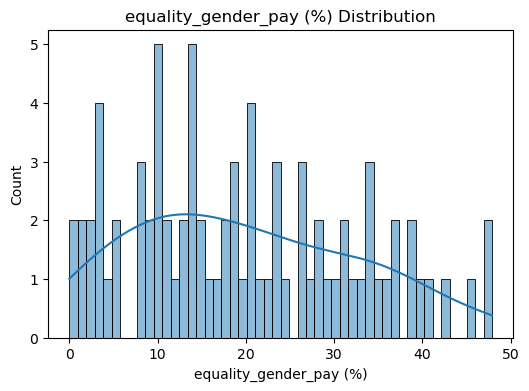

In [250]:
numeric_list = ['equality_gender_pay (%)']

skew_df = data_5[numeric_list].skew().reset_index()
skew_df.columns = ['Column', 'Skewness']


kurt_df = data_5[numeric_list].kurt().reset_index()
kurt_df.columns = ['Column', 'Kurtosis']

stats_df = pd.merge(skew_df, kurt_df, on='Column')

print(stats_df)

for col in numeric_list:  
    plt.figure(figsize=(6,4))
    sns.histplot(data_5[col], bins = 50, kde=True)
    plt.title(f"{col} Distribution")
    plt.show()

| Variable | Relationship | Imputation Method |
|----------|-------------|-------------------|
| **equality_gender_pay** | Distribution is roughly normal, continuous, not strongly skewed, and median is robust to small irregularities | **Median** |


In [251]:
#  equality_gender_pay  (%) imputation

median_value = data_5['equality_gender_pay (%)'].median()

data_5['equality_gender_pay (%)'] = (
    data_5['equality_gender_pay (%)'].fillna(median_value)
)

In [252]:
data_20 = data_5.copy()

### Group 3 — Missing  20-40% of Data

| **20–40%**| Advanced imputation                        | • Multivariate imputation (MICE, kNN) 

In [254]:
gr_40

['equality_gender_bonus (%)', 'equality_gender_pay_previous (%)']

In [255]:
# Run randomness test

filtered_cols = missing_percent[missing_percent < 40].index

# Create a new DataFrame with only those columns
data_filtered = data_20[filtered_cols]

# Apply to filtered dataset

assessment = assess_randomness(data_filtered, gr_40, threshold=0.3)
print('Filtered')
for target, info in assessment.items():
    print(f"{target}:")
    print(f"  Result: {info['result']}")
    if info['correlated_columns']:
        print(f"  Correlated with:")
        for col, corr_val in info['correlated_columns']:
            print(f"    - {col}: {corr_val:.3f}")
    else:
        print(f"  Correlated with: []")
    print()


Filtered
equality_gender_bonus (%):
  Result: Not Random (MAR/MNAR)
  Correlated with:
    - equality_gender_pay_previous (%): 0.584
    - equality_gender_pay (%): 0.573
    - equality_female_employees (%): 0.363

equality_gender_pay_previous (%):
  Result: Not Random (MAR/MNAR)
  Correlated with:
    - equality_gender_bonus (%): 0.584
    - equality_gender_pay (%): 0.980



| Variable | Relationship Type | Recommended Imputation Method |
|-----------|-------------------|-------------------------------|
| **equality_gender_pay_previous** | Srong correlation with gender_pay | Linear regression |
| **equality_gender_bonus** | MAR Moderate relationship | MICE |

#### equality_gender_pay_previous	

In [256]:
# Separate complete and incomplete cases
complete_cases = data_20[['equality_gender_pay (%)', 'equality_gender_pay_previous (%)']].dropna()
missing_cases = data_20[data_20['equality_gender_pay_previous (%)'].isna()].copy()

# Fit linear regression on complete cases
X_train = complete_cases[['equality_gender_pay (%)']].values
y_train = complete_cases['equality_gender_pay_previous (%)'].values

model = LinearRegression()
model.fit(X_train, y_train)

# Calculate residual standard error for stochastic component
y_pred_train = model.predict(X_train)
residuals = y_train - y_pred_train
residual_std = np.std(residuals)

# Predict for missing cases
X_missing = missing_cases[['equality_gender_pay (%)']].values
y_pred = model.predict(X_missing)

# Add stochastic noise
np.random.seed(42)  # For reproducibility
stochastic_noise = np.random.normal(0, residual_std, size=len(y_pred))
y_imputed = y_pred + stochastic_noise

# Fill in the missing values
data_20.loc[data_20['equality_gender_pay_previous (%)'].isna(), 'equality_gender_pay_previous (%)'] = y_imputed

print(f"Imputed {len(y_imputed)} missing values")
print(f"Model R²: {model.score(X_train, y_train):.4f}")
print(f"Residual standard error: {residual_std:.4f}")


Imputed 24 missing values
Model R²: 0.9595
Residual standard error: 2.5506


#### equality_gender_bonus	

In [257]:
# Define the model
et_est = ExtraTreesRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

mice_et = IterativeImputer(
    estimator=et_est,
    max_iter=50,
    sample_posterior=False,
    imputation_order="random",
    random_state=42
)

In [258]:
# Define the dataset

sparse_cols = [
    "equality_bame_pay (%)",            
    "equality_lgbt_pay (%)",          
    "equality_lgbt_management (%)",    
    "equality_disability_pay (%)",     
    "equality_disability_management (%)"  
]

In [264]:
df = data_20.copy()  
target_col = "equality_gender_bonus (%)"

#  Drop ultra-sparse columns
cols_for_mice = [c for c in df.columns if c not in sparse_cols]

# Include the target in MICE so it can be imputed
mice_data = df[cols_for_mice].copy()

# Fit MICE 
mice_imputed = pd.DataFrame(
    mice_gb.fit_transform(mice_data),
    columns=mice_data.columns,
    index=mice_data.index
)

#  Imputed values 
df_imputed = df.copy()
missing_mask = df_imputed[target_col].isna()

df_imputed.loc[missing_mask, target_col] = mice_imputed.loc[missing_mask, target_col]

# df_imputed now has 'equality_gender_bonus (%)' fully filled
print("Number of missing in target BEFORE:", df[target_col].isna().sum())
print("Number of missing in target AFTER :", df_imputed[target_col].isna().sum())

# Evaluate predictive performance
known_mask = df[target_col].notna()

X = mice_imputed.loc[known_mask].drop(columns=[target_col])
y = df.loc[known_mask, target_col]

gb_eval = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42
)

cv_mae = cross_val_score(gb_eval, X, y, cv=5, scoring="neg_mean_absolute_error")
cv_r2  = cross_val_score(gb_eval, X, y, cv=5, scoring="r2")

mean_mae = -cv_mae.mean()
mean_r2 = cv_r2.mean()

print("\n### Gradient Boosting Evaluation (known targets only)")
print(f"MAE: {mean_mae:.2f}")
print(f"R² : {mean_r2:.3f}")


/opt/anaconda3/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Number of missing in target BEFORE: 25
Number of missing in target AFTER : 0

### Gradient Boosting Evaluation (known targets only)
MAE: 11.04
R² : 0.452


In [274]:
# Merging predicted values with the main dataset

missing_mask = data_20["equality_gender_bonus (%)"].isna()
data_20.loc[missing_mask, "equality_gender_bonus (%)"] = df_imputed.loc[missing_mask, "equality_gender_bonus (%)"]


In [275]:
data_40 = data_20.copy()


### Group 4 — Missing  40-60% of Data

| **40–60%**| Domain-specific imputation **or** consider remain unfilled | • Model- or domain-based (e.g., regression, time-series inference)<br>• Remain unfilled if imputation is not feasible ||

In [360]:
gr_60

['equality_leave_secondary (W)',
 'equality_leave_primary (W)',
 'equality_gender_pay_improvement (%)']

In [278]:
#  Run Randomness test

filtered_cols = missing_percent[missing_percent < 60].index

# Create a new DataFrame with only those columns
data_filtered = data_20[filtered_cols]

# Apply to filtered dataset
assessment = assess_randomness(data_filtered, gr_60, threshold=0.3)
print('Filtered')
for target, info in assessment.items():
    print(f"{target}:")
    print(f"  Result: {info['result']}")
    if info['correlated_columns']:
        print(f"  Correlated with:")
        for col, corr_val in info['correlated_columns']:
            print(f"    - {col}: {corr_val:.3f}")
    else:
        print(f"  Correlated with: []")
    print()
    

Filtered
equality_leave_secondary (W):
  Result: Not Random (MAR/MNAR)
  Correlated with:
    - equality_leave_primary (W): 0.450

equality_leave_primary (W):
  Result: Not Random (MAR/MNAR)
  Correlated with:
    - equality_leave_secondary (W): 0.450

equality_gender_pay_improvement (%):
  Result: Not Random (MAR/MNAR)
  Correlated with:
    - equality_gender_pay_previous (%): 0.346



| Variable | Relationship Type | Recommended Imputation Method |
|-----------|-------------------|-------------------------------|
| **equality_leave_secondary** | Correlation with equality_leave_primary |**Linear regression** using a observed correlated column |
| **equality_leave_primary** | Correlation with equality_leave_secondary| **Linear regression** using a observed correlated column |
| **equality_gender_pay_improvement** | Weak prediction with only one column| Remain unfilled |

####  equality_leave_primary

In [333]:
# Find how many values can be predicted

checking_df = data_40[[primary, secondary]]

primary = 'equality_leave_primary (W)'
secondary = 'equality_leave_secondary (W)'

# Primary missing, secondary present
primary_missing_secondary_present = checking_df[
    checking_df[primary].isna() & checking_df[secondary].notna()
]

# Secondary missing, primary present
secondary_missing_primary_present = checking_df[
    checking_df[secondary].isna() & checking_df[primary].notna()
]

# Both missing
both_missing = checking_df[
    checking_df[primary].isna() & checking_df[secondary].isna()
]

# Both present
both_present = checking_df[
    checking_df[primary].notna() & checking_df[secondary].notna()
]

# --- PRINT COUNTS ---
print("Primary missing, Secondary present:", primary_missing_secondary_present.shape[0])
print("Secondary missing, Primary present:", secondary_missing_primary_present.shape[0])
print("Both missing:", both_missing.shape[0])
print("Both present:", both_present.shape[0])


Primary missing, Secondary present: 1
Secondary missing, Primary present: 10
Both missing: 48
Both present: 40


In [ ]:
#Define the model

model_primary = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    max_depth=None,
    min_samples_leaf=2
)



In [347]:
df = data_40[[primary, secondary]].copy()

# Masks
m_primary_only  = df[primary].isna() & df[secondary].notna()
m_secondary_only = df[secondary].isna() & df[primary].notna()
m_both_missing = df[primary].isna() & df[secondary].isna()

# Impute primary from secondary
train_primary = df[df[primary].notna() & df[secondary].notna()]

# Train model
model_primary.fit(train_primary[[secondary]], train_primary[primary])

# R2 / MAE on training data
primary_preds = model_primary.predict(train_primary[[secondary]])
primary_r2 = r2_score(train_primary[primary], primary_preds)
primary_mae = mean_absolute_error(train_primary[primary], primary_preds)

print("Model 1: PRIMARY ~ SECONDARY (Random Forest)")
print(f"  R²:  {primary_r2:.4f}")
print(f"  MAE: {primary_mae:.4f}\n")

# Impute missing primary
df.loc[m_primary_only, primary] = model_primary.predict(
    df.loc[m_primary_only, [secondary]]
)

# Impute secondary from primary

# Training data (rows where both are present)
train_secondary = df[df[secondary].notna() & df[primary].notna()]

# Fit model: secondary = f(primary)
model_secondary = LinearRegression()
model_secondary.fit(
    train_secondary[[primary]],
    train_secondary[secondary]
)

# Compute metrics
secondary_preds = model_secondary.predict(train_secondary[[primary]])
secondary_r2 = r2_score(train_secondary[secondary], secondary_preds)
secondary_mae = mean_absolute_error(train_secondary[secondary], secondary_preds)

print("Model 2: SECONDARY ~ PRIMARY")
print(f"  R²:  {secondary_r2:.4f}")
print(f"  MAE: {secondary_mae:.4f}\n")

# Predict missing secondary
df.loc[m_secondary_only, secondary] = model_secondary.predict(
    df.loc[m_secondary_only, [primary]]
)


Model 1: PRIMARY ~ SECONDARY (Random Forest)
  R²:  0.3703
  MAE: 4.2383

Model 2: SECONDARY ~ PRIMARY
  R²:  0.2024
  MAE: 4.9237



In [352]:
data_40[primary] = df[primary]
data_40[secondary] = df[secondary]

In [354]:
#  Run Randomness test to see if any new predictors appear

filtered_cols = missing_percent[missing_percent < 60].index

# Create a new DataFrame with only those columns
data_filtered = data_40[filtered_cols]

# Random or Not Random based on correlations
# Apply to filtered dataset

assessment = assess_randomness(data_filtered, gr_60, threshold=0.3)
print('Filtered')
for target, info in assessment.items():
    print(f"{target}:")
    print(f"  Result: {info['result']}")
    if info['correlated_columns']:
        print(f"  Correlated with:")
        for col, corr_val in info['correlated_columns']:
            print(f"    - {col}: {corr_val:.3f}")
    else:
        print(f"  Correlated with: []")
    print()

Filtered
equality_leave_secondary (W):
  Result: Not Random (MAR/MNAR)
  Correlated with:
    - equality_leave_primary (W): 0.504

equality_leave_primary (W):
  Result: Not Random (MAR/MNAR)
  Correlated with:
    - equality_leave_secondary (W): 0.504

equality_gender_pay_improvement (%):
  Result: Not Random (MAR/MNAR)
  Correlated with:
    - equality_gender_pay_previous (%): 0.346



In [355]:
final_dataset = data_40.copy()

In [356]:
missing_percent = data_40.isna().mean() * 100
missing_percent = missing_percent.sort_values(ascending=False)
missing_percent

equality_disability_management (%)     100.000000
equality_disability_pay (%)            100.000000
equality_lgbt_management (%)           100.000000
equality_lgbt_pay (%)                  100.000000
equality_bame_pay (%)                   96.969697
equality_lgbt_employees (%)             92.929293
equality_bame_management (%)            89.898990
equality_disability_employees (%)       88.888889
equality_bame_employees (%)             79.797980
equality_female_graduates (%)           69.696970
equality_leave_secondary (W)            48.484848
equality_leave_primary (W)              48.484848
equality_gender_pay_improvement (%)     46.464646
equality_wise (Y/N)                      0.000000
equality_wise_level ,Level(4-0)          0.000000
equality_gender_appointments (%)         0.000000
equality_female_management (%)           0.000000
equality_gender_directors (%)            0.000000
equality_gender_bonus (%)                0.000000
equality_gender_pay (%)                  0.000000


In [363]:
final_dataset.to_csv('Project_csv/filled_dataset.csv')